In [1]:
import numpy as np
import skimage.transform
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


## Dictionary to map file keys from STScI to Krist

In [2]:
telap_key_map = {'hex1':'hex1', 'hex2':'hex2', 'hex3':'hex3', 'hex4':'hex4',
                 'key24':'keystone24', 'pie08':'piewedge8', 'pie12':'piewedge12'}
secobs_key_map = {'Cross':'cross', 'X':'x'}

## set directory of telescope aperture and list contents

In [3]:
#telap_dir = os.path.abspath('../Apertures/JPL/offset_masks')
telap_dir = os.path.normpath('/astro/opticslab1/SCDA/Apertures/JPL/offset_masks')
#print telap_dir
#print("Contents:")
#os.listdir(telap_dir)

In [4]:
#new_telap_dir = os.path.abspath("../InputMasks/TelAp")
new_telap_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks/TelAp")
if not os.path.exists(new_telap_dir):
    os.mkdir(new_telap_dir)
    print("created {:s} for binned aperture arrays".format(new_telap_dir))
else:
    print("Destination {:s} already exists".format(new_telap_dir))

Destination /astro/opticslab1/SCDA/Apertures/InputMasks/TelAp already exists


## Set basic parameters

In [5]:
prim_key = "hex4"
secobs_key = "X"
centobs = True
D = 2000
N = 500 # quadrant width after binning

## Load an aperture and a secondary obstruction, plot the product

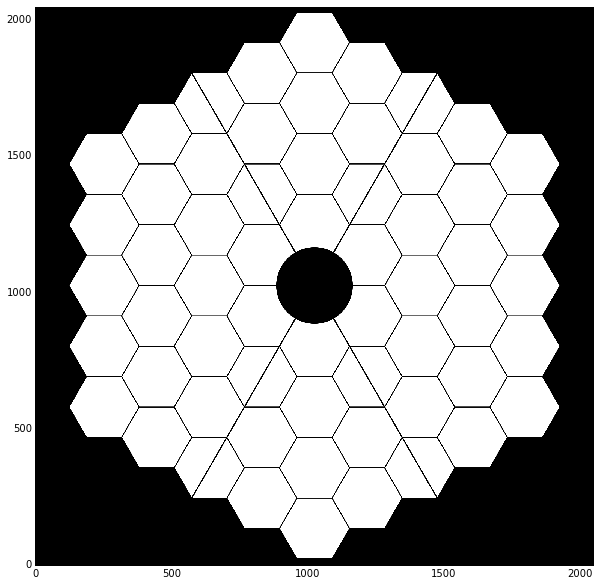

In [6]:
if centobs is True:
    telap_fname = os.path.join(telap_dir, "{0:s}_{1:04d}pix_offset.fits".format(telap_key_map[prim_key], D))
    secobs_fname = os.path.join(telap_dir, "{0:s}_spiders_{1:04d}pix_2.5cm_offset.fits".format(
                                           secobs_key_map[secobs_key], D))
else:
    telap_fname = os.path.join(telap_dir, "{0:s}_{1:04d}pix_offset_no_central_obsc.fits".format(telap_key_map[prim_key], D))
    secobs_fname = os.path.join(telap_dir, "{0:s}_spiders_{1:04d}pix_2.5cm_offset.fits".format(
                                           secobs_key_map[secobs_key], D))
    
telap_hdulist = fits.open(telap_fname, "readonly")
telap_orig = telap_hdulist[0].data
telap_hdulist.close()
secobs_hdulist = fits.open(secobs_fname, "readonly")
secobs = secobs_hdulist[0].data
secobs_hdulist.close()
telap_obs = telap_orig*secobs
plt.figure(figsize=(10,10))
#plt.imshow(telap_orig)
plt.imshow(telap_obs)

### Test the symmetry

In [7]:
L = telap_obs.shape[0]
telap_left = telap_obs[:,:L/2] # left half
telap_right = telap_obs[:,L/2:] # right half
telap_top = telap_obs[L/2:,:] # left half
telap_bot = telap_obs[:L/2,:] # right half
leftright_diff = telap_left - telap_right[:,::-1]
topbot_diff = telap_top - telap_bot[::-1,:]
max_abs_leftright_diff = np.max(np.abs(leftright_diff))
max_abs_topbot_diff = np.max(np.abs(topbot_diff))
print('Max absolute left-right difference = {:g}'.format(max_abs_leftright_diff))
print('Max absolute top-bottom difference = {:g}'.format(max_abs_topbot_diff))

Max absolute left-right difference = 9.96289e-06
Max absolute top-bottom difference = 2.3898e-05


In [8]:
#plt.figure(figsize=(10,6))
#plt.subplot(121)
#plt.imshow(leftright_diff)
#plt.colorbar()
#plt.subplot(122)
#plt.imshow(topbot_diff.T)
#plt.colorbar()

## Bin to abritrary integer size, crop to quadrant

In [9]:
#N_orig = 1000 # not 1024
#scalefac = float(N)/N_orig
#telap_bin = scipy.ndimage.zoom(telap_obs, scalefac, order=1)
#telap_bin = skimage.transform.rescale(telap_obs, scalefac, order=1)
#L_bin = telap_bin.shape[0]

In [10]:
N_orig = D/2
scalefac = int(N_orig/N)
print("Binning the original aperture array {0:d}x".format(scalefac))
telap_bin = np.reshape(telap_obs,(telap_obs.shape[0]/scalefac, scalefac, 
                                  telap_obs.shape[1]/scalefac, scalefac)).mean(1).mean(2)
L_bin = telap_bin.shape[0]

Binning the original aperture array 2x


In [11]:
telap_bin.shape

(1024, 1024)

In [12]:
telap_binquad = telap_bin[L_bin/2:L_bin/2+N, L_bin/2:L_bin/2+N]
telap_binquad.shape
# Check max value of outer row and outer column
print np.max(telap_binquad[-1,:])
print np.max(telap_binquad[:,-1])

1.0
0.0


(-0.5, 499.5, -0.5, 499.5)

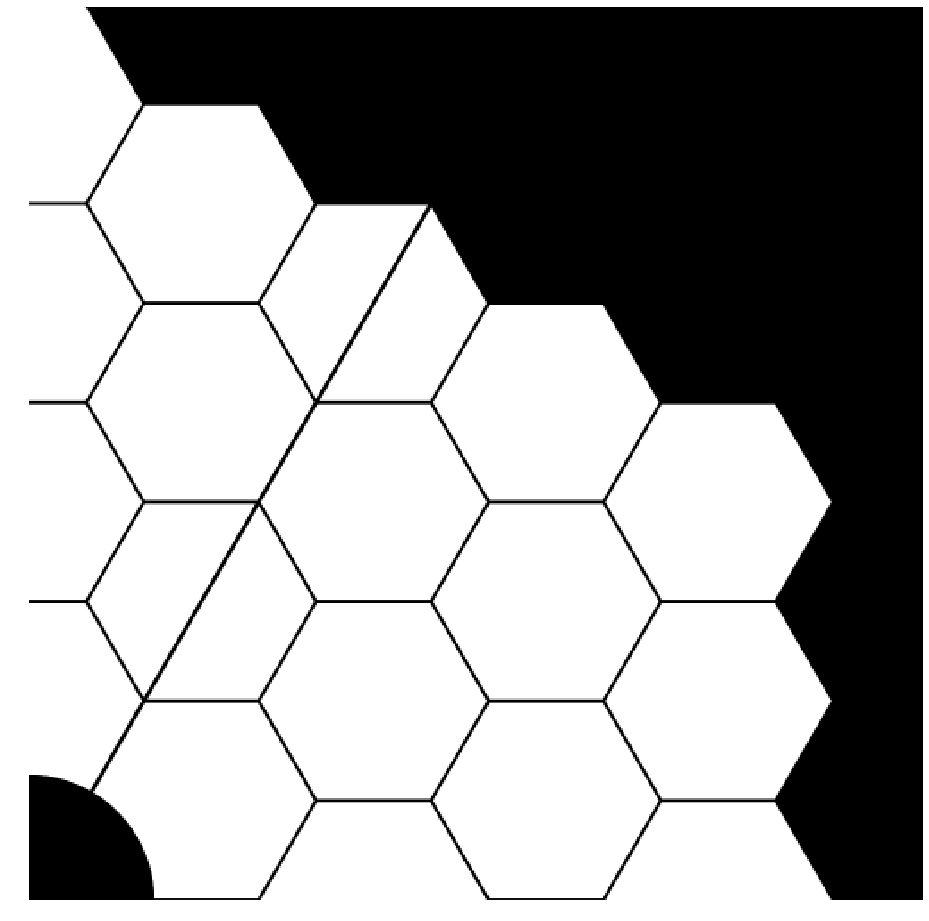

In [13]:
plt.figure(figsize=(16,16))
plt.imshow(telap_binquad)
#plt.imshow(np.floor(telap_binquad))
#plt.imshow(telap_binquad.astype(int))
plt.axis('off')

### Form new FITS filename and write

In [14]:
if centobs is True:
    telap_binquad_dat_fname_tail = "TelAp_quart_{0:s}{1:s}025cobs1_N{2:04d}.dat".format(prim_key, secobs_key, N)
    telap_binquad_dat_fname = os.path.join(new_telap_dir, telap_binquad_dat_fname_tail)
else:
    telap_binquad_dat_fname_tail = "TelAp_quart_{0:s}{1:s}025cobs0_N{2:04d}.dat".format(prim_key, secobs_key, N)
    telap_binquad_dat_fname = os.path.join(new_telap_dir, telap_binquad_dat_fname_tail)

#telap_binquad_fits_fname_tail = "TelAp_quart_{0:s}_{1:s}025sm1_N{2:04d}.fits".format(telap_key, secobs_key, N)
#telap_binquad_fits_fname = os.path.join(binned_telap_dir, telap_binquad_fits_fname_tail)

In [15]:
#telap_binquad_hdu = fits.PrimaryHDU(telap_binquad)
#telap_binquad_hdu.writeto(telap_binquad_fits_fname, clobber=True)

In [16]:
np.savetxt(telap_binquad_dat_fname, telap_binquad, fmt='%.6f', delimiter=" ")
print("Wrote binned, cropped telescope aperture array to {0:s}".format(telap_binquad_dat_fname))

Wrote binned, cropped telescope aperture array to /astro/opticslab1/SCDA/Apertures/InputMasks/TelAp/TelAp_quart_hex4X025cobs1_N0500.dat


In [17]:
os.listdir(new_telap_dir)

['TelAp_quart_hex4X025cobs1_N0250.dat',
 'TelAp_quart_hex1X025cobs1_N0250.dat',
 'TelAp_quart_hex2X025cobs1_N0250.dat',
 'TelAp_quart_hex3X025cobs1_N0250.dat',
 'TelAp_quart_hex1X025cobs1_N0125.dat',
 'TelAp_quart_hex3X025cobs1_N0125.dat',
 'TelAp_quart_hex2X025cobs1_N0125.dat',
 'TelAp_quart_hex4X025cobs1_N0125.dat',
 'TelAp_quart_hex4X025cobs1_N0500.dat']

In [18]:
#telap_load = np.loadtxt(telap_binquad_dat_fname)

In [19]:
#plt.figure(figsize=(16,16))
#plt.imshow(np.floor(telap_load))